<a href="https://colab.research.google.com/github/po1itepeop1e/Sentiments-Analysis/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240128%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240128T170047Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D81559dfe25bdaa6e88b63528872151615d3b945f6c06b5a479c2f000d6cf5560eebaaac784782ffd456a9b3cde86c24da71b9ffae677a09d4407b4ab89ba34bc9f8474ad570c2934b36e121ef6ccfd69ba8c5da78a986f9970fe529c6fe7a5305d20ecc0c0c00d587664fc0a3a1123874f791c18c2cf5279c446e0024a452d4c1db2d3c57e4a6e0639dfb8411f68e2b76f4869b0d0a1f7df7b1758778ddbf339f0997271863f8b0dff94294ee3dd153c34db56b529616a43dd1f8ad25b955a66b87244b4aa858d6e992c7ee24fa7d4b7162f4ae678ca2de52c72c6a17eb9c0705dcc7212d260694509a77abcb28f56bd3ff9032f906a66fc9ade55b73ca23214'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


**CNN Cancer Detection**

*1. Brief description of the problem and data*

*In this dataset, there are pathology images to be classified. The images are named with an ID, and the train_labels.csv file provides the correct labels for the images in the train folder. The task is to predict the labels for the images in the test folder. A positive label indicates that the central 32x32px region of a patch contains at least one pixel of tumor tissue. The tumor tissue in the outer region of the patch does not affect the label, and this outer region is included to support fully-convolutional models.*

In [2]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
os.listdir('/kaggle/input/histopathologic-cancer-detection/')

['train_labels.csv', 'sample_submission.csv', 'train', 'test']

In [4]:
train_lab = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [5]:
train_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
train_lab.describe()

label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

In [7]:
train_lab.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

*In this dataset, there are a large number of small pathology images provided for classification. Each image is identified by a unique image id. The train_labels.csv file contains the ground truth for the images in the train folder, and the task is to predict the labels for the images in the test folder. A positive label indicates the presence of tumor tissue in the center 32x32px region of a patch, while tumor tissue in the outer region does not affect the label. The dataset contains 220,025 entries, and there are two columns: id, which is a unique identifier for each image patch, and label, a binary indicator of the presence (1) or absence (0) of tumor tissue in the image patch.*

*2. Exploratory Data Analysis (EDA)*

In [8]:
from PIL import Image
from PIL import Image, ImageDraw

In [9]:
malignant = train_lab.loc[train_lab['label']==1]['id'].values
benign = train_lab.loc[train_lab['label']==0]['id'].values
imgpath ="/kaggle/input/histopathologic-cancer-detection/train/"

def plot_fig(ids,title,nrows=5,ncols=15):
    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(np.array(img))
        plt.axis('off')
    plt.suptitle(title, y=0.94)

****************************************************************************************************


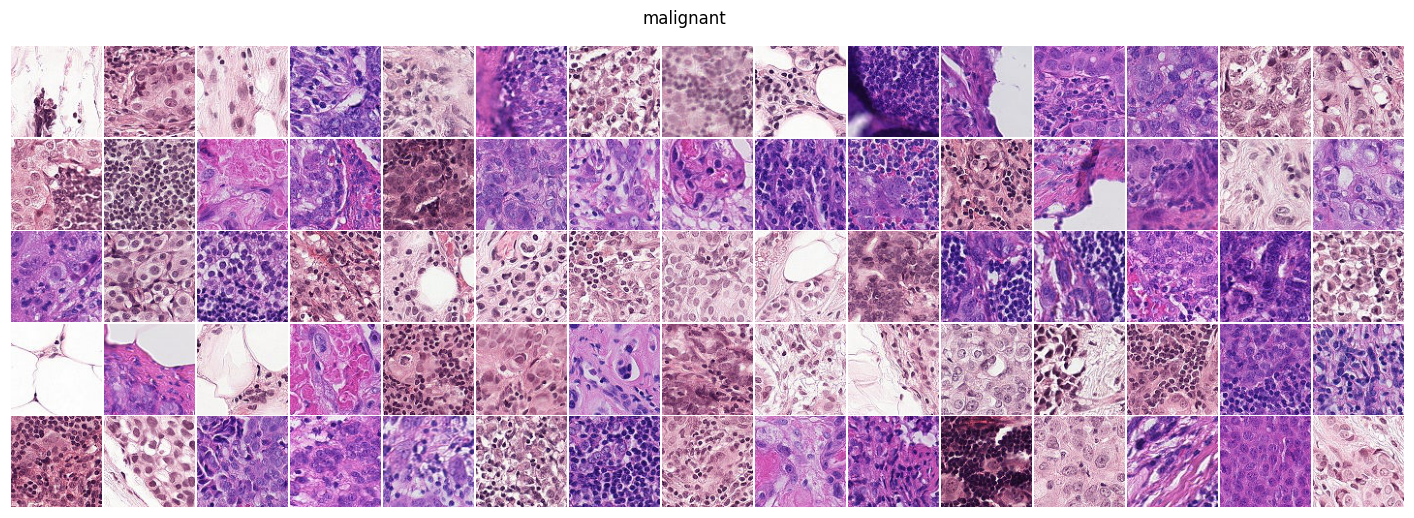

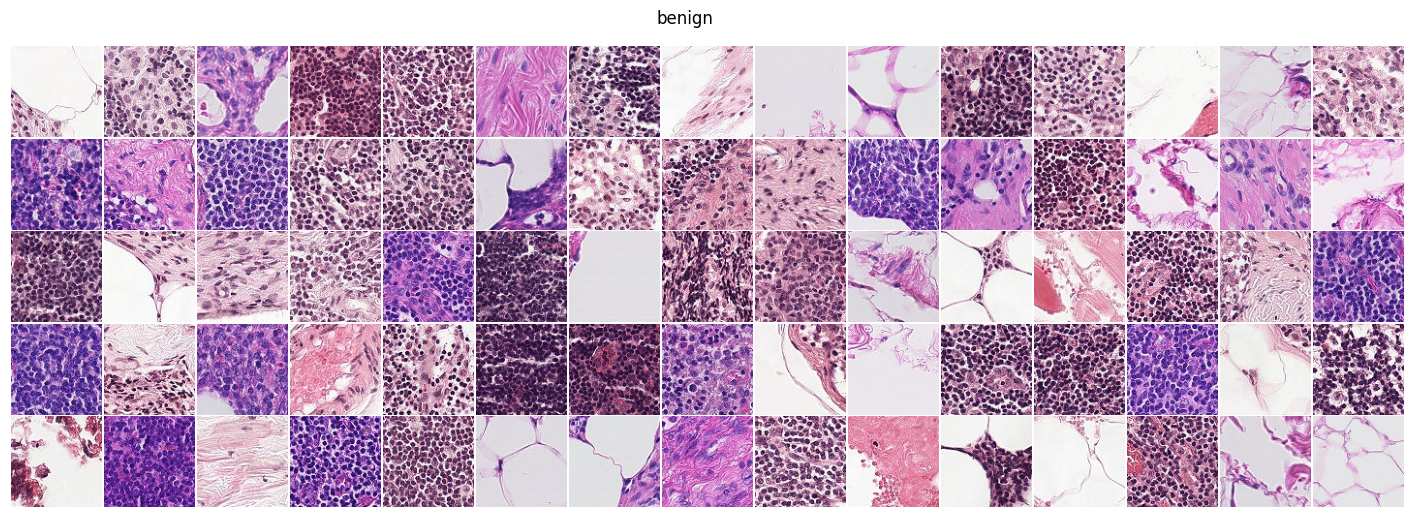

In [10]:
plot_fig(malignant,'malignant')

print("****************************************************************************************************")

plot_fig(benign,'benign')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

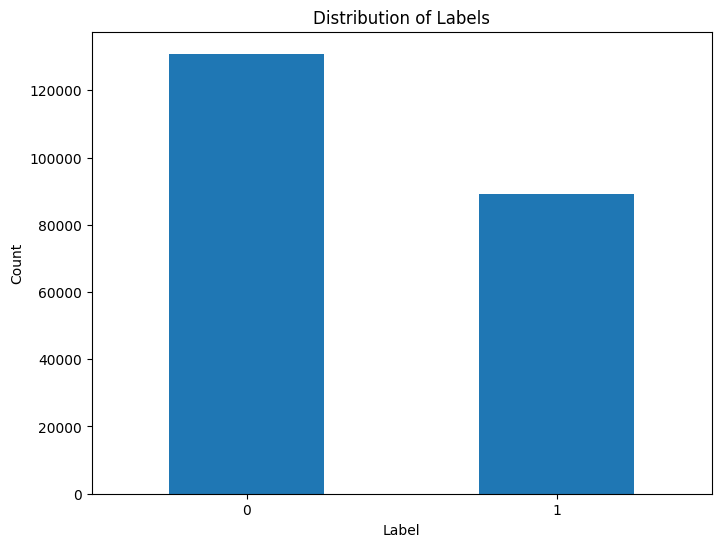

In [12]:
label_counts = train_lab['label'].value_counts()
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

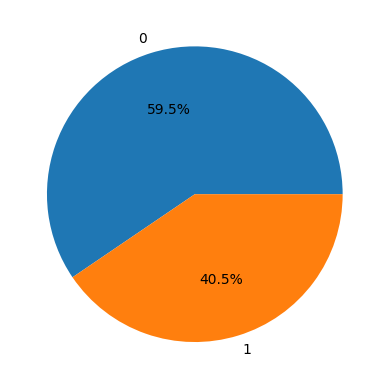

In [13]:
unique_labels, counts = np.unique(train_lab.label.values, return_counts=True)
plt.pie(counts/np.sum(counts), labels=unique_labels, autopct='%1.1f%%')
plt.show()

*The image is a 96x96 pixel RGB image of cells from a tissue sample. The training labels are stored in a file called train_labels.csv, which assigns a label to each image based on its filename. About 40.5% of the images show cancerous cells, while the remaining 59.5% show non-cancerous cells. Though there is a slight imbalance, it is not significant enough to require any operations to balance the dataset at this stage.*

In [14]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [15]:
def make_train_path(id_str):
    return os.path.join(r"/kaggle/input/histopathologic-cancer-detection/train", f"{id_str}.tif")

*The task requires transforming the 'label' column into a string format to meet the requirements of the binary data generators used in Keras, which expect label data in string format for classification tasks. This means converting the numerical labels into strings before feeding the data into the model training process.*

In [16]:
train_lab["filename"] = train_lab["id"].apply(make_train_path)
train_lab["label"] = train_lab["label"].astype(str)
train_lab.head()

id label  \
0  f38a6374c348f90b587e046aac6079959adf3835     0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1   
2  755db6279dae599ebb4d39a9123cce439965282d     0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0   
4  068aba587a4950175d04c680d38943fd488d6a9d     0   

                                            filename  
0  /kaggle/input/histopathologic-cancer-detection...  
1  /kaggle/input/histopathologic-cancer-detection...  
2  /kaggle/input/histopathologic-cancer-detection...  
3  /kaggle/input/histopathologic-cancer-detection...  
4  /kaggle/input/histopathologic-cancer-detection...

In [17]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_lab,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

Found 176020 non-validated image filenames belonging to 2 classes.


In [18]:
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_lab,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

Found 44005 non-validated image filenames belonging to 2 classes.


In [19]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_data = pd.DataFrame()
test_data["id"] = test_ids
test_data["filename"] = test_filenames

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col="filename",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=64,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


**3. DModel Architecture**

*The architecture consists of sequential layers of Conv2D, pooling, and dense layers, with a sigmoid output for binary classification. This model will be used as a baseline to compare the effectiveness of more complex architectures and additional techniques used in the enhanced model. It incorporates advanced techniques such as dropout for regularization, batch normalization for faster and stable training, and the Adam optimizer with a specific learning rate for efficient learning. These enhancements are expected to improve the model's ability to generalize and perform better on unseen data.*

*classic model*

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [22]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(32, 64, 64, 3))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [23]:
test_model = model.fit(train_generator,
                       steps_per_epoch=len(train_generator),
                       validation_data=validation_generator,
                       validation_steps=len(validation_generator),
                       epochs=10,
                       callbacks=[reduce, earlystop])

Epoch 1/10
5501/5501 [==============================] - 444s 79ms/step - loss: 0.4470 - accuracy: 0.7842 - auc: 0.8659 - val_loss: 0.3552 - val_accuracy: 0.8472 - val_auc: 0.9193 - lr: 0.0010
Epoch 2/10
5501/5501 [==============================] - 392s 71ms/step - loss: 0.3396 - accuracy: 0.8549 - auc: 0.9259 - val_loss: 0.3380 - val_accuracy: 0.8566 - val_auc: 0.9303 - lr: 0.0010
Epoch 3/10
5501/5501 [==============================] - 364s 66ms/step - loss: 0.3041 - accuracy: 0.8710 - auc: 0.9405 - val_loss: 0.3084 - val_accuracy: 0.8693 - val_auc: 0.9428 - lr: 0.0010
Epoch 4/10
5501/5501 [==============================] - 367s 67ms/step - loss: 0.2742 - accuracy: 0.8849 - auc: 0.9518 - val_loss: 0.3051 - val_accuracy: 0.8731 - val_auc: 0.9422 - lr: 0.0010
Epoch 5/10
5501/5501 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9000 - auc: 0.9627
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5501/5501 [==============================] 

**4. Results and Analysis**

In [38]:
print(test_model.history.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])


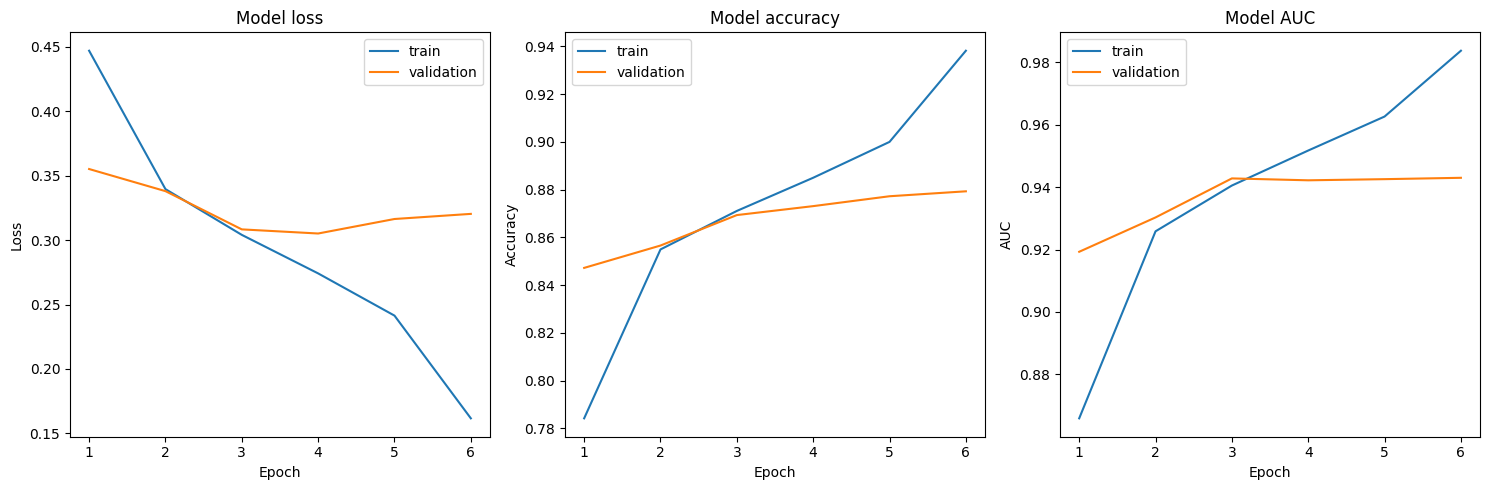

In [44]:
epochs = np.arange(1, len(test_model.history["val_loss"]) + 1, 1)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(epochs, test_model.history["loss"], label="train")
axs[0].plot(epochs, test_model.history["val_loss"], label="validation")
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].plot(epochs, test_model.history["accuracy"], label="train")
axs[1].plot(epochs, test_model.history["val_accuracy"], label="validation")
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

axs[2].plot(epochs, test_model.history["auc"], label="train")
axs[2].plot(epochs, test_model.history["val_auc"], label="validation")
axs[2].set_title('Model AUC')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Epoch')
axs[2].legend()

plt.tight_layout()
plt.show()

In [49]:
action = model.predict(test_generator, verbose=1)

898/898 [==============================] - 99s 109ms/step


In [51]:
results = np.transpose(action)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, results))
submission_df.head()

id  label
0  2cd1496342ea66d057c18ed8cf96bcfbb355b773      0
1  4247ebcc283f9702e2ee6d49aec817782016c602      1
2  fbdbd9d47f52d5ab8a4420303e943b9610e4719f      1
3  c3036ad0b8cb2225e108c018fdb7f3314764c93c      0
4  58f9d2036249d5f610023acf25436d8dd1075e40      0

In [52]:
submission_df.to_csv('submission.csv', index=False)

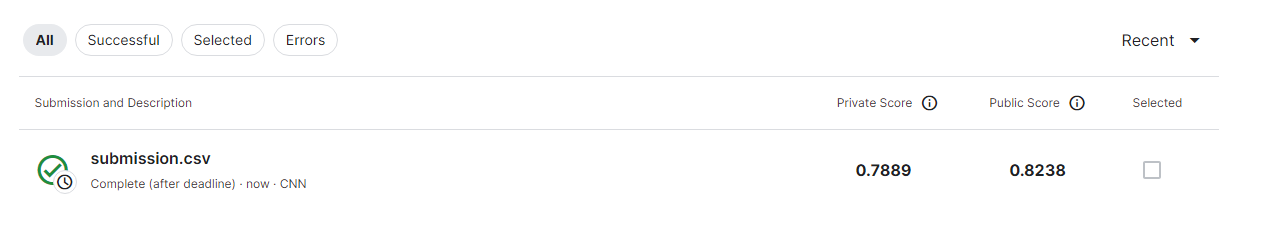